In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# torch.manual_seed(1)

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# input_size = 2 
hidden_size = 2048 # randomly chosen
output_size = 1 # we want it to return a number that can be used to calculate the difference from the actual number

class NeuralNetwork(nn.Module):
    def __init__(self,img_dim, output_size):
        
        super(NeuralNetwork, self).__init__()
        
        
        # weights 
#         self.W = torch.randn(img_dim,img_dim , requires_grad=True)

#         self.theta_D = torch.randn(num_img, img_dim, requires_grad=True)
        
        
        self.W = nn.Linear(img_dim,img_dim)
        
        self.discriminator_thetaD = nn.Linear(img_dim,hidden_size)
        self.discriminator_hiddn = nn.Linear(hidden_size,output_size)


        
# Add bias
        self.b1 = torch.randn(img_dim, requires_grad=True)

#         self.b2 = torch.randn(hidden_size, requires_grad=True)
#         self.b3 = torch.randn(output_size, requires_grad=True)
        
        
    def forward(self, inp_matrix,phase='Discriminate',typeinp='img'):
        
        if phase == 'Discriminate' and typeinp=='img':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            wTx = self.W(inp_matrix)

            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Discriminate' and typeinp=='text':

            self.W.trainable = False
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
#             wTx = self.W(img)

            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out=out.view(-1)

            return nn.Sigmoid()(out)

        if phase == 'Map' and typeinp=='img' :
            self.W.trainable = True
            
            wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            discriminator_hidden_in = self.discriminator_thetaD(wTx)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out = out.view(-1)
            return nn.Sigmoid()(out)
            
        if phase == 'Map' and typeinp=='text' :
            self.W.trainable = True
            
#             wTx = self.W(inp_matrix)
            
            self.discriminator_thetaD.trainable = True
            self.discriminator_hiddn.trainable = True
            
            
            discriminator_hidden_in = self.discriminator_thetaD(inp_matrix)
            out = self.discriminator_hiddn(discriminator_hidden_in)
            out = out.view(-1)
            return nn.Sigmoid()(out)

            


In [4]:
dimension_space = 300

nne = NeuralNetwork(dimension_space,1).cuda()

In [5]:

learning_rate = 0.01

# create a stochastic gradient descent optimizer
# optimizer = optim.SGD(nne.parameters(), lr=learning_rate, momentum=0.9)

# optimizer = optim.Adam([var1, var2], lr = 0.0001)

optimizer = optim.Adam(nne.parameters(), lr = 0.0001)

# create a loss function
criterion = nn.BCELoss().cuda()

In [6]:
nne

NeuralNetwork(
  (W): Linear(in_features=300, out_features=300, bias=True)
  (discriminator_thetaD): Linear(in_features=300, out_features=2048, bias=True)
  (discriminator_hiddn): Linear(in_features=2048, out_features=1, bias=True)
)

In [7]:
import numpy as np

num_instances = 30000

input_img = np.random.rand(num_instances,300)
input_text = np.random.rand(num_instances,300)

In [8]:
input_img

array([[0.30118619, 0.97147817, 0.90739673, ..., 0.20052922, 0.58402608,
        0.64244229],
       [0.31228533, 0.08658259, 0.46036738, ..., 0.79125167, 0.55696168,
        0.90531643],
       [0.53810014, 0.65404965, 0.46719798, ..., 0.60218714, 0.72229862,
        0.1451442 ],
       ...,
       [0.16606507, 0.04041566, 0.75443041, ..., 0.4717844 , 0.18769346,
        0.86843122],
       [0.54472299, 0.05319084, 0.54300585, ..., 0.76250699, 0.45422427,
        0.59743321],
       [0.85952011, 0.84122319, 0.37563033, ..., 0.8523958 , 0.79826001,
        0.57862031]])

In [9]:
num_epochs = 50

In [10]:
discriminator_img_loss = []
discriminator_text_loss = []
mapper_loss = []
mapper_text_loss = []

In [11]:
for epoch in range(num_epochs):
    
    ## Discriminate. For image, it is 1, saying it comes from different distribution
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate',typeinp='img')
    
    targets = (torch.ones(num_instances).cuda()).fill_(0.8)  # Smoothing suggested by GoodFellow
    
    loss = criterion(outed,targets)
    discriminator_img_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Discriminate. For text, it is 0 saying it is text, from same distribution 
    outed = nne( Variable(torch.from_numpy(input_text)).cuda().float(),phase='Discriminate',typeinp='text')
    targets = (torch.zeros(num_instances).cuda()).fill_(0.2)
    
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    
    
    discriminator_text_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()

    ## Mapper , Training in a way to fool discriminator think that vector from image distribution is from text distribution. 
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Map',typeinp='img')
    loss = criterion(outed,torch.zeros(num_instances).cuda())
    mapper_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()
    
    ## Mapper , Training in a way to fool discriminator think that vector from text distribution is from image distribution. 
    outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Map',typeinp='text')
    loss = criterion(outed,torch.ones(num_instances).cuda())
    mapper_text_loss.append(loss.cpu().tolist())
    loss.backward()
    optimizer.step()
    
    

In [12]:
discriminator_img_loss

[0.6695547103881836,
 0.579840362071991,
 0.6581844687461853,
 0.8130216598510742,
 0.9736844897270203,
 1.0933665037155151,
 1.1232757568359375,
 1.0558875799179077,
 0.9994058609008789,
 1.060308575630188,
 1.3016475439071655,
 1.7012057304382324,
 2.0043270587921143,
 1.8481793403625488,
 1.223922610282898,
 0.6303509473800659,
 0.5101397633552551,
 0.642173707485199,
 0.7560222744941711,
 0.7639652490615845,
 0.663918137550354,
 0.526583194732666,
 0.5570906400680542,
 1.0050132274627686,
 1.6942968368530273,
 2.2353034019470215,
 2.424466609954834,
 2.1994478702545166,
 1.5892982482910156,
 0.8233149647712708,
 0.5018765330314636,
 0.7322710156440735,
 1.0481308698654175,
 1.2143055200576782,
 1.1511948108673096,
 0.8771669268608093,
 0.5385106801986694,
 0.8435590863227844,
 2.393254280090332,
 4.017762660980225,
 5.157205104827881,
 5.662835597991943,
 5.495542526245117,
 4.690162658691406,
 3.3467066287994385,
 1.693976640701294,
 0.5645899772644043,
 0.6553760170936584,
 1.023

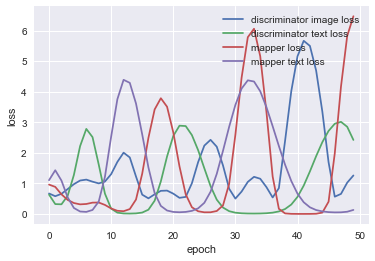

In [14]:
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot([i for i in range(num_epochs)],discriminator_img_loss,label='discriminator image loss')
plt.plot([i for i in range(num_epochs)],discriminator_text_loss,label='discriminator text loss')
plt.plot([i for i in range(num_epochs)],mapper_loss,label='mapper loss')
plt.plot([i for i in range(num_epochs)],mapper_text_loss,label='mapper text loss')
plt.legend(loc='upper right')

## tSNE demo

In [1]:
from sklearn.manifold import TSNE


In [11]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')


In [12]:
import numpy as np
test_inp = np.random.rand(1000,300)

In [13]:
tsne_lda = tsne_model.fit_transform(test_inp)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.046859
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.876915
[t-SNE] Error after 1000 iterations: 2.854912


In [14]:
import numpy as np
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool

n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

In [15]:
num_example = test_inp.shape[0]
title='visual trials'
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x=tsne_lda[:, 0], y=tsne_lda[:, 1],source=bp.ColumnDataSource({"content": test_inp,}))



C:\Users\kmura\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\Users\kmura\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


GlyphRenderer(id='eb91ac40-4d61-4d10-87ed-dfc44b0b1276', ...)

In [16]:
# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content - topic: @topic_key"}

# save the plot
save(plot_lda, '{}.html'.format(title))

C:\Users\kmura\Anaconda3\lib\site-packages\bokeh\io.py:405: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warnings.warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\Users\kmura\Anaconda3\lib\site-packages\bokeh\io.py:415: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warnings.warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'D:\\SEM 7\\Core Project\\MyCode\\Adversarial Training\\visual trials.html'

# Just checking the updatability property

In [33]:
outed = nne( Variable(torch.from_numpy(input_img)).cuda().float(),phase='Discriminate')

torch.Size([1000, 300])
tensor([ 0.0243,  0.0047, -0.0256, -0.0169, -0.0442, -0.0453, -0.1131,  0.0551,
        -0.0461,  0.0131,  0.0519,  0.0186, -0.0191, -0.0738, -0.0868, -0.0707,
        -0.0226,  0.0006, -0.0329,  0.0205, -0.0221,  0.0183,  0.0319,  0.0362,
         0.0515,  0.0514, -0.0122, -0.0770, -0.0497,  0.0008, -0.0819,  0.0071,
        -0.0512, -0.0012,  0.0327, -0.0019, -0.0556, -0.0267, -0.0287, -0.0166,
         0.0016, -0.0660,  0.0065, -0.0451,  0.0758, -0.0044,  0.0253, -0.0338,
        -0.0209, -0.0469,  0.0516, -0.0378, -0.0738,  0.0784, -0.1040, -0.0703,
         0.0091, -0.0075,  0.0051,  0.0458, -0.0339, -0.0340, -0.0475, -0.0467,
        -0.0878, -0.0285, -0.1398, -0.0908, -0.0277, -0.1045, -0.0224, -0.0489,
         0.0037,  0.0161, -0.0523, -0.0347,  0.0011, -0.0794, -0.0041,  0.0271,
         0.0117, -0.1007,  0.0237, -0.0649, -0.0836, -0.1281,  0.0106,  0.0707,
        -0.1287, -0.0866,  0.0326, -0.0007, -0.0241, -0.1051, -0.0956, -0.0516,
         0.0193,

In [ ]:
nne.W.weight

In [ ]:
nne.discriminator_thetaD.weight

In [31]:
nne.discriminator_hiddn.weight

Parameter containing:
tensor([[ 0.0006,  0.0216,  0.0131, -0.0242,  0.0107, -0.0143, -0.0436, -0.0113,
          0.0087, -0.0412, -0.0004, -0.0240,  0.0111, -0.0146,  0.0184, -0.0101,
          0.0460, -0.0332,  0.0337, -0.0290, -0.0135,  0.0047,  0.0121, -0.0353,
          0.0155,  0.0205, -0.0298, -0.0323,  0.0456,  0.0313, -0.0143,  0.0055,
          0.0454, -0.0184,  0.0489,  0.0112, -0.0038, -0.0038,  0.0149,  0.0404,
         -0.0413, -0.0286, -0.0194, -0.0440,  0.0348, -0.0469, -0.0143, -0.0333,
         -0.0257, -0.0161,  0.0096, -0.0213, -0.0126, -0.0290, -0.0162,  0.0383,
         -0.0332, -0.0217,  0.0303, -0.0425,  0.0075, -0.0311, -0.0349, -0.0366,
          0.0443, -0.0250,  0.0287, -0.0406, -0.0266,  0.0068, -0.0145, -0.0291,
         -0.0063,  0.0451, -0.0136,  0.0085, -0.0191, -0.0369, -0.0268,  0.0104,
          0.0069, -0.0217,  0.0350, -0.0035, -0.0396, -0.0074,  0.0164,  0.0444,
          0.0185,  0.0406, -0.0122, -0.0413,  0.0199, -0.0208,  0.0218, -0.0325,
      

In [32]:
outed.shape

torch.Size([1000])

In [21]:
loss = criterion(outed,torch.ones(1000))
loss.backward()
optimizer.step()

In [22]:
nne.W.weight

Parameter containing:
tensor([[ 0.0297, -0.0255, -0.0112,  ...,  0.0007, -0.0330, -0.0323],
        [-0.0087, -0.0167,  0.0141,  ..., -0.0150, -0.0009,  0.0567],
        [ 0.0388, -0.0043,  0.0566,  ...,  0.0475, -0.0140,  0.0021],
        ...,
        [ 0.0479,  0.0255,  0.0026,  ..., -0.0493, -0.0470,  0.0084],
        [-0.0123, -0.0536, -0.0290,  ...,  0.0452,  0.0064, -0.0413],
        [ 0.0074,  0.0007,  0.0109,  ..., -0.0207,  0.0500,  0.0514]],
       requires_grad=True)

In [23]:
nne.discriminator_thetaD.weight

Parameter containing:
tensor([[-0.0299, -0.0288, -0.0171,  ...,  0.0355,  0.0556, -0.0168],
        [ 0.0153, -0.0307,  0.0017,  ..., -0.0024, -0.0273,  0.0022],
        [-0.0444, -0.0501, -0.0237,  ..., -0.0554, -0.0141,  0.0302],
        ...,
        [ 0.0416, -0.0026, -0.0562,  ..., -0.0080, -0.0514, -0.0418],
        [ 0.0553,  0.0548, -0.0161,  ..., -0.0388, -0.0459, -0.0495],
        [ 0.0285,  0.0144, -0.0449,  ..., -0.0126,  0.0344, -0.0138]],
       requires_grad=True)